In [1]:
import pandas as pd
import numpy as np
from osgeo import ogr, osr
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
import os
import yaml
from sentinelhub import DataSource
from sentinelhub import CustomUrlParam
from pyproj import Proj, transform
import math
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("../../config.yaml", 'r') as stream:
    key = (yaml.safe_load(stream))
    API_KEY = key['key']
    AWSKEY = key['awskey']
    AWSSECRET = key['awssecret']

In [3]:
dates = ('2019-6-15', '2020-01-15')
coord = (-90.8, 15.3)

In [4]:
def calculate_epsg(points):
    """ Calculates the UTM EPSG of an input WGS 84 lon, lat

        Parameters:
         points (tuple): input longitiude, latitude tuple
    
        Returns:
         epsg_code (int): integer form of associated UTM EPSG
    """
    lon, lat = points[0], points[1]
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+ utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return int(epsg_code)

def calculate_bbx_pyproj(coord, step_x, step_y, expansion, multiplier = 1.):
    ''' Calculates the four corners of a bounding box
        but uses pyproj instead of OGR. It seems sentinelhub uses
        pyproj, so this may be more pixel accurate
    '''
    
    inproj = Proj('epsg:4326')
    outproj_code = calculate_epsg(coord)
    print(outproj_code)
    outproj = Proj('epsg:' + str(outproj_code))
    
    
    
    coord_utm =  transform(inproj, outproj, coord[1], coord[0])
    coord_utm_bottom_left = (coord_utm[0] + step_x*6300 - expansion,
                             coord_utm[1] + step_y*6300 - expansion)
    coord_utm_top_right = (coord_utm[0] + (step_x+multiplier) * 6300 + expansion,
                           coord_utm[1] + (step_y+multiplier) * 6300 + expansion)
    
    coord_bottom_left = transform(outproj, inproj,
                                  coord_utm_bottom_left[0],
                                  coord_utm_bottom_left[1])
    
    coord_top_right = transform(outproj, inproj,
                                  coord_utm_top_right[0],
                                  coord_utm_top_right[1])
    
    zone = str(outproj_code)[3:]
    direction = 'N' if coord[1] >= 0 else 'S'
    utm_epsg = "UTM_" + zone + direction
    return (coord_utm_bottom_left, coord_utm_top_right), CRS[utm_epsg]

# D32F cloud probabilities

32615


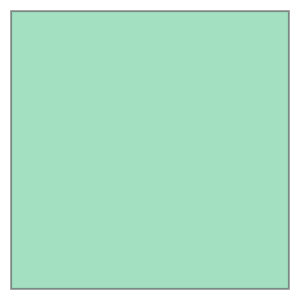

In [5]:
bbox, epsg = calculate_bbx_pyproj(coord, 0, 0, 10)
box = BBox(bbox, crs = epsg)
box

In [6]:
bbox

((736223.75843693, 1692694.9503758464), (742543.75843693, 1699014.9503758464))

### The `WmsRequest` gets the following JSON:

```json
{
	"@id": "https://services.sentinel-hub.com/configuration/v1/wms/instances/[API_KEY_HERE]/layers/CLOUD_NEW",
	"id": "CLOUD_NEW",
	"title": "CLOUD_NEW",
	"description": "",
	"styles": [
		{
			"name": "default",
			"description": "Default layer style",
			"evalScript": "return [CLP]"
		}
	],
	"orderHint": 0,
	"instance": {
		"@id": "https://services.sentinel-hub.com/configuration/v1/wms/instances/[API_KEY_HERE]"
	},
	"dataset": {
		"@id": "https://services.sentinel-hub.com/configuration/v1/datasets/S2L1C"
	},
	"datasetSource": {
		"@id": "https://services.sentinel-hub.com/configuration/v1/datasets/S2L1C/sources/1"
	},
	"defaultStyleName": "default",
	"datasourceDefaults": {
		"mosaickingOrder": "mostRecent",
		"maxCloudCoverage": 75,
		"temporal": false,
		"type": "S2L1C"
	},
	"user_data": {}
}
```

In [51]:
# start at 1064
# end at 1214
image_request = WcsRequest(
        layer="SENT",
        bbox=box,
        time=dates,
        image_format = MimeType.TIFF_d16,
        data_source=DataSource.SENTINEL1_IW,
        maxcc=1.0,
        resx='5m', resy='5m',
        instance_id=API_KEY,
        custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                            constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
        time_difference=datetime.timedelta(hours=96),
    )
data_filter = None
img_bands = image_request.get_data()

In [52]:
size_f = (img_bands[0].shape[0]**2)/(512*512)
number = len(img_bands)
number_bands = (2/3)
grd = 1
expected = size_f * number * number_bands * grd
print(expected)

150.33658854166666


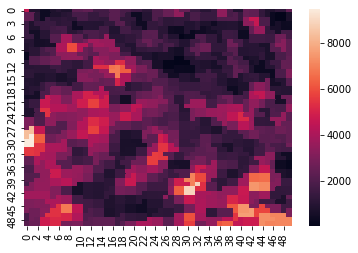

In [58]:
sns.heatmap(img_bands[8][200:250, 200:250, 1])

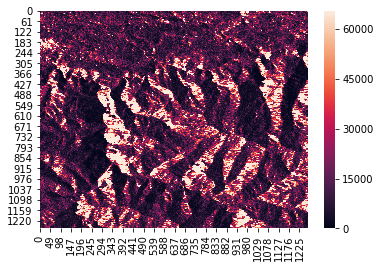

In [48]:
sns.heatmap(img_bands[0][:, :, 0])

In [71]:
# start at 1064
# end at 1214
image_request = WcsRequest(
        layer="SENT",
        bbox=box,
        time=dates,
        image_format = MimeType.TIFF_d16,
        data_source=DataSource.SENTINEL1_IW,
        maxcc=1.0,
        resx='10m', resy='5m',
        instance_id=API_KEY,
        custom_url_params = {constants.CustomUrlParam.DOWNSAMPLING: 'NEAREST',
                            constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
        time_difference=datetime.timedelta(hours=96),
    )
data_filter = None
x20 = image_request.get_data()

In [72]:
from skimage.transform import resize
x20_1 = np.stack(x20, axis = 0)
x20_1 = resize(x20_1, (x20_1.shape[0], 632*2, 632*2, 2), order = 0)

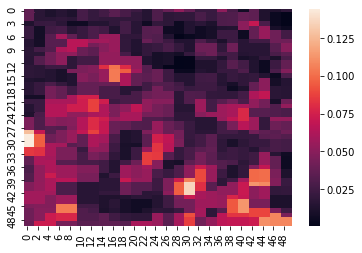

In [73]:
sns.heatmap(x20_1[8, 200:250, 200:250, 1])

In [74]:
size_f = (x20[0].shape[0]*x20[0].shape[1])/(512*512)
number = len(x20)
number_bands = (2/3)
grd = 1
expected = size_f * number * number_bands * grd
print(expected)

75.16829427083333


## The d32 tiff correctly shows cloud probabilities from 0 to 255

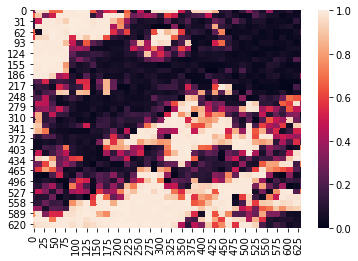

In [12]:
sns.heatmap(d32f_data[5])

# D8 cloud probabilities

In [8]:
cloud_request = WmsRequest(
    layer='CLOUD_NEW',
    bbox=box,
    time=dates,
    width=632,
    height=632,
    image_format = MimeType.TIFF_d8,
    maxcc=0.7,
    instance_id=API_KEY,
    custom_url_params = {constants.CustomUrlParam.UPSAMPLING: 'NEAREST'},
    time_difference=datetime.timedelta(hours=72),
)

d8_data = cloud_request.get_data()

# The d8 tiff is wonky (?)

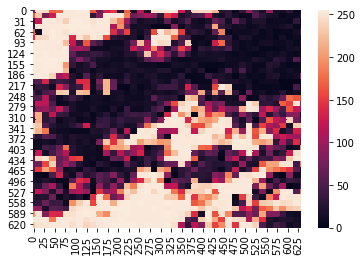

In [9]:
sns.heatmap(d8_data[5])

# The scatterplot between d8 and d32 is wonky

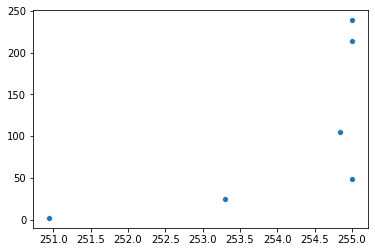

In [32]:
d8_means = np.mean(d8_data, axis = (1, 2))
d32_means = np.mean(d32f_data, axis = (1, 2))


sns.scatterplot(d8_means, d32_means)

# There is an average 40% difference between d8 and d32

In [38]:
print(f"{(np.sum(abs(np.array(d8_data) - np.array(d32f_data))) / np.sum(d32f_data)) * 100} %")

140.6973958015442 %
